# Bikes 🚲

[Lecture slides](https://docs.google.com/presentation/d/1lQ3AcIMXd1pNFiAroYExzLOLq2HGSWrJj0p8OL8vT8Q/edit#slide=id.p22)

----

The data from today is about bike sharing demand from [a previously held Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand/data).  Below is a bit of documentation from the competition.

---

> You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
>
> Data Fields
> ```
> datetime - hourly date + timestamp  
> season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
> holiday - whether the day is considered a holiday
> workingday - whether the day is neither a weekend nor holiday
> weather - 1: Clear, 
>              Few clouds,
>              Partly cloudy, 
>              Partly cloudy
>           2: Mist + Cloudy, 
>              Mist + Broken clouds, 
>              Mist + Few clouds,
>              Mist
>           3: Light Snow,
>              Light Rain + Thunderstorm + Scattered clouds, 
>              Light Rain + Scattered clouds
>           4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, 
>              Snow + Fog 
> temp - temperature in Celsius
> atemp - "feels like" temperature in Celsius
> humidity - relative humidity
> windspeed - wind speed
> casual - number of non-registered user rentals initiated
> registered - number of registered user rentals initiated
> count - number of total rentals
> ```

From this list of column descriptions.

* What columns are categorical?  Which of these do you think we'll need to one-hot-encode?
* Do you see any columns that you expect to be multicollinear?

In the Kaggle competition the challenge was to predict the `count` column.  The `casual` and `registered` columns aren't allowed to be used since that information is really just the `count` column broken out into its components (i.e. `count = casual + registered`).

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")


def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

### Let's do some general EDA

In [4]:
# data from https://www.kaggle.com/c/bike-sharing-demand/data
data_url = "https://docs.google.com/spreadsheets/d/1GJrx_Y3cvD1sWLg_zF_mMZZ0iZ_If2E02VIkyCi3PTc/export?format=csv"
bike_sharing = pd.read_csv(data_url)
bike_sharing.shape

(10886, 12)

<IPython.core.display.Javascript object>

In [5]:
bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<IPython.core.display.Javascript object>

The column `datetime` itself isn't very useful.  Why is that and how might we get some useful info out of the column?

In [6]:
bike_sharing["datetime"] = pd.to_datetime(bike_sharing["datetime"])
bike_sharing["weekday"] = bike_sharing["datetime"].dt.day_name()
bike_sharing["hour"] = bike_sharing["datetime"].dt.hour
bike_sharing["month"] = bike_sharing["datetime"].dt.month

bike_sharing.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,hour,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,Saturday,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,Saturday,1,1


<IPython.core.display.Javascript object>

Drop the datetime column

In [7]:
bike_sharing = bike_sharing.drop(columns=["datetime"])
bike_sharing.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,hour,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,Saturday,0,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,Saturday,1,1


<IPython.core.display.Javascript object>

Investigate the column datatypes to make sure there's nothing unexpected

In [8]:
bike_sharing.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
weekday        object
hour            int64
month           int64
dtype: object

<IPython.core.display.Javascript object>

Do we have missing values we need to handle?

In [9]:
bike_sharing.isna().mean()

season        0.0
holiday       0.0
workingday    0.0
weather       0.0
temp          0.0
atemp         0.0
humidity      0.0
windspeed     0.0
casual        0.0
registered    0.0
count         0.0
weekday       0.0
hour          0.0
month         0.0
dtype: float64

<IPython.core.display.Javascript object>

Calculate summary statistics.  When doing this, pay extra attention to our response variable, `count`.

In [10]:
bike_sharing.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,6.521495
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,3.444373
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,4.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,7.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,10.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,12.000000


<IPython.core.display.Javascript object>

Plot a `scatter_matrix`/`pairplot` of our dataframe

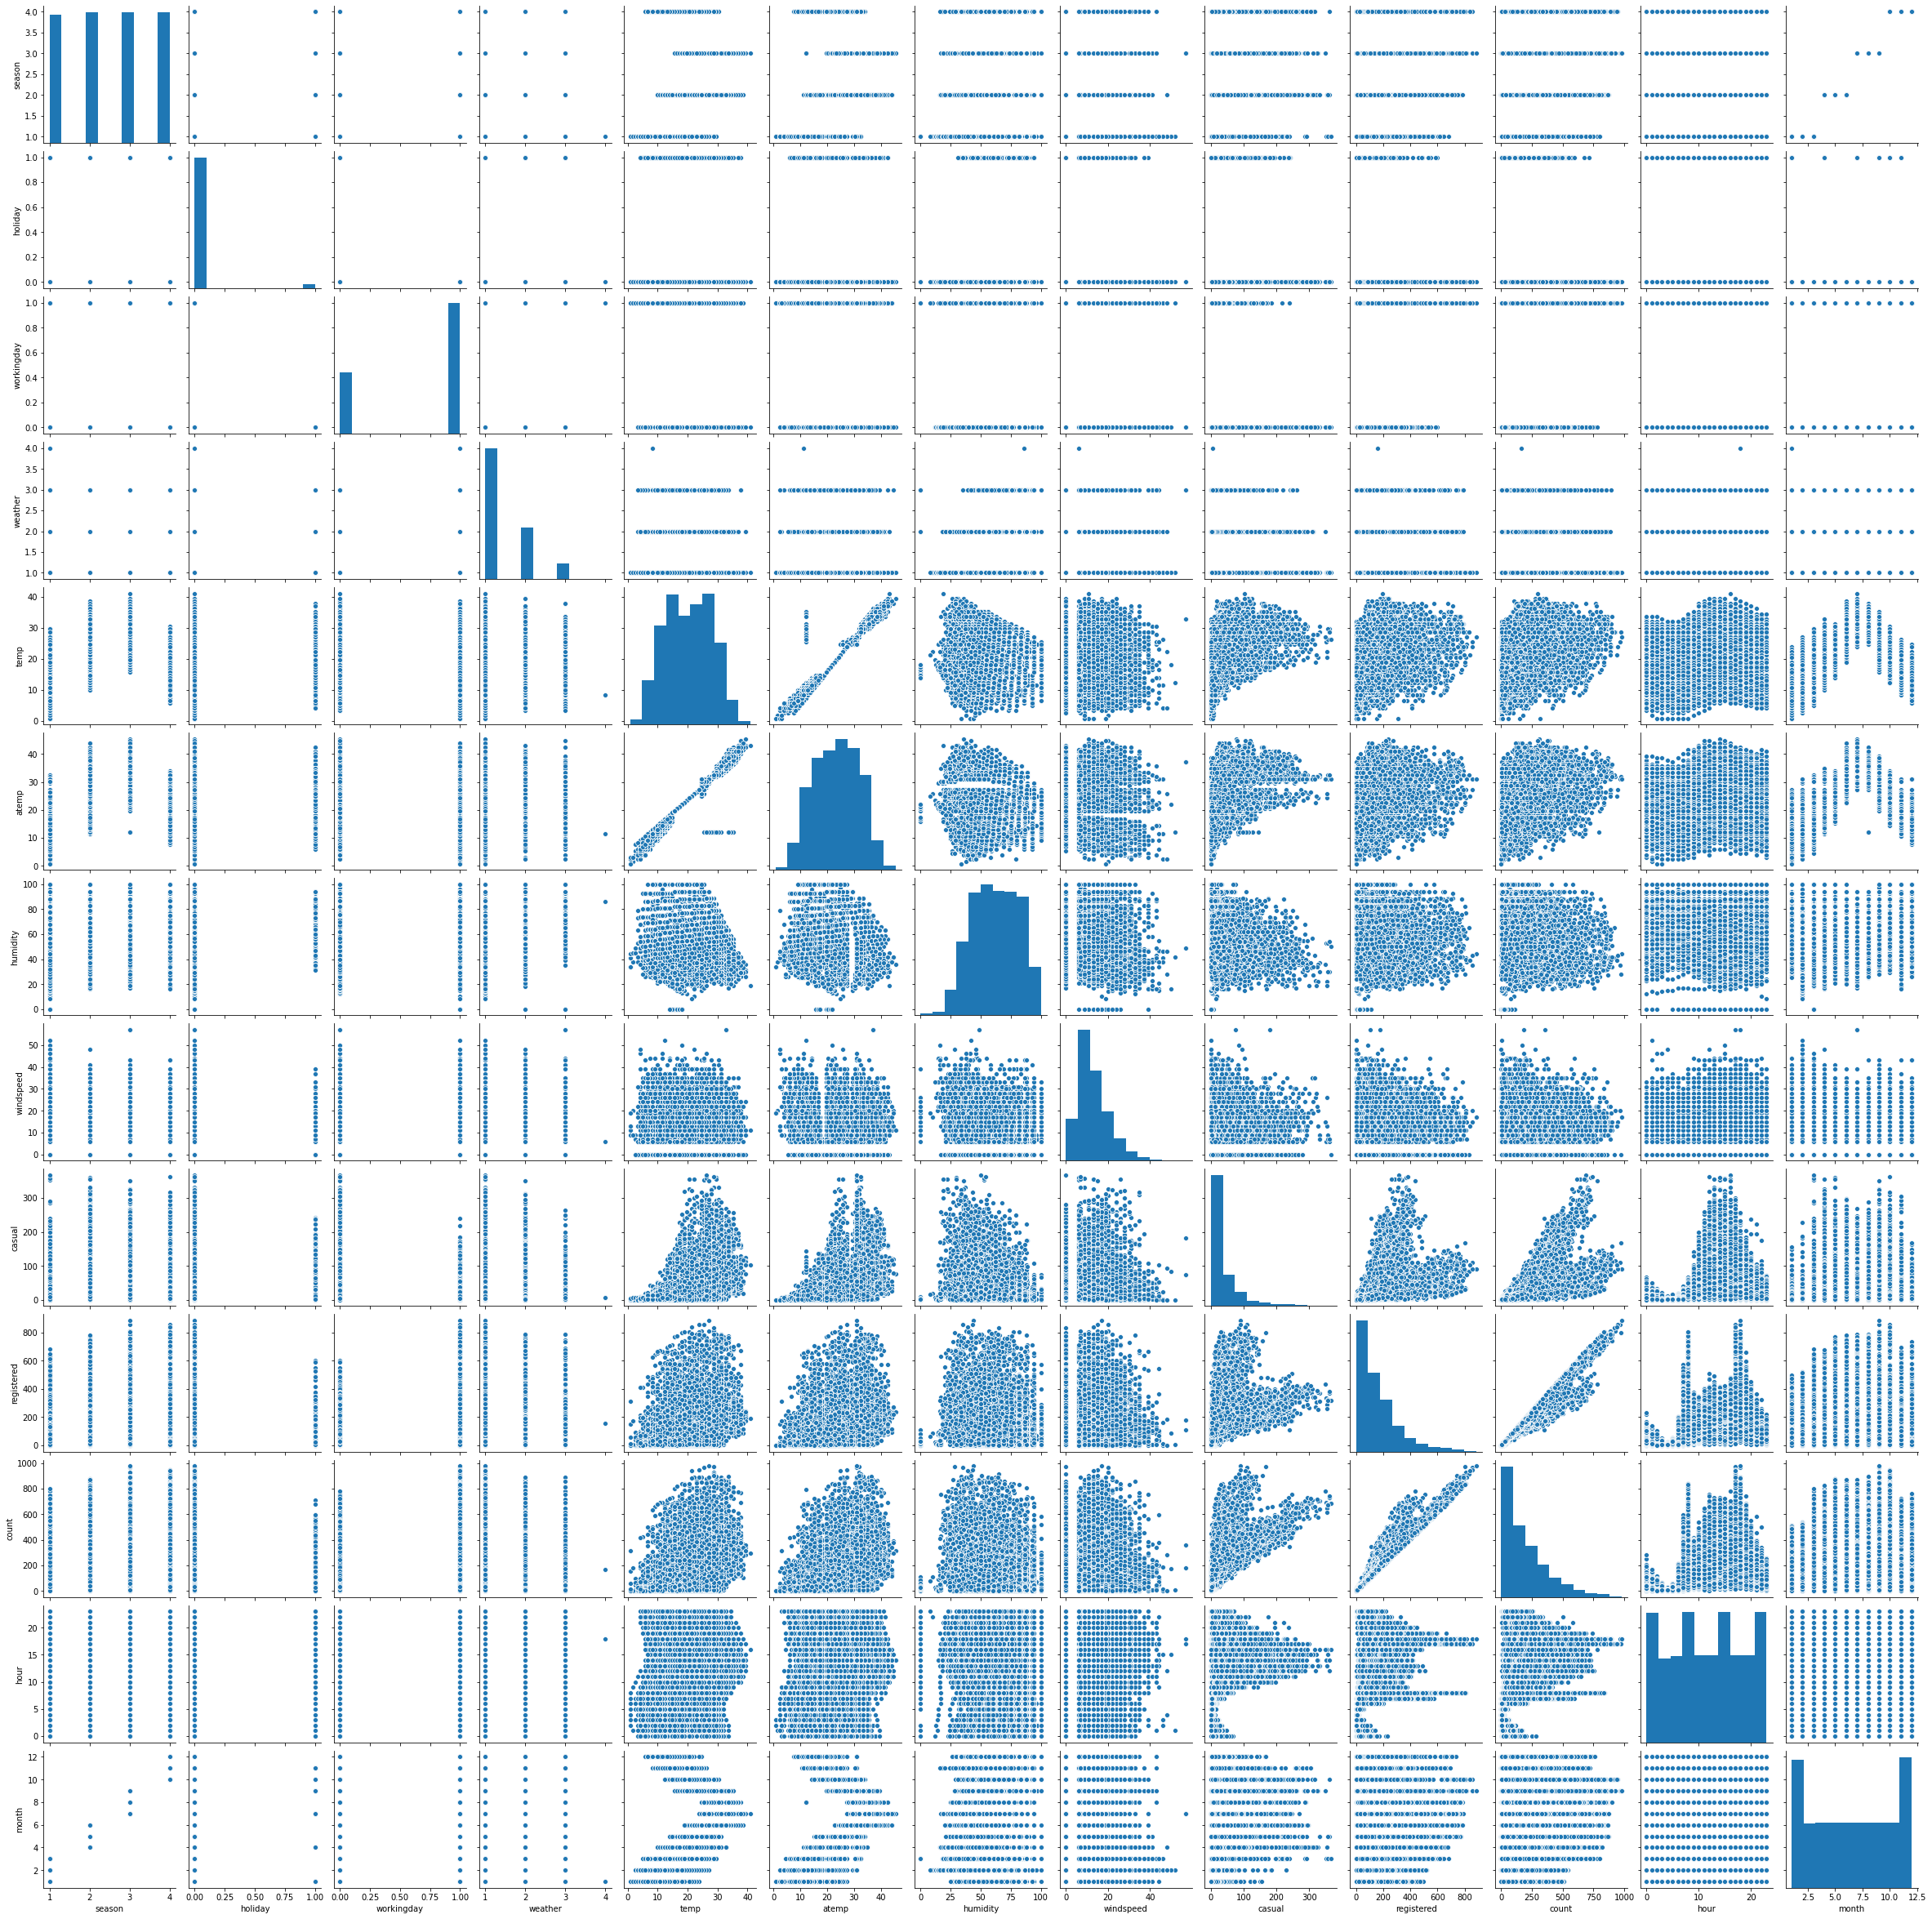

<IPython.core.display.Javascript object>

In [11]:
sns.pairplot(bike_sharing)
plt.show()

Some things to point out.

* Its not the strongest thing, but, temperature seems to have an effect on rentals (the higher the temp the more rentals).  This effect seems more prominent in the casual rentals.
* Both humidity and windspeed seem to have negative effects.  When they're low, there doesn't seem to be a big correlation, but when these factors are high we see a drop off in rentals.
* We won't be using this information, but note the plots between casual & count.  We see a pretty distinct v-shape, this is indicative of an interaction happening somewhere.  That is, there seems to be 2 distinct groups of data, we could try and explore and find a reason for this split.
* Our response variable `count` is a very positively skewed distribution.  This indicates that we might want to perform a transformation to it.  For now we'll leave it, and come back to this.

Plot the distribution of the response

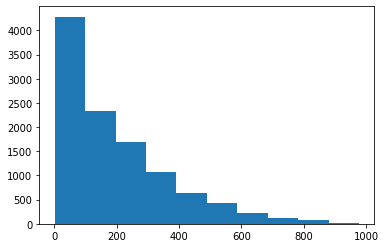

<IPython.core.display.Javascript object>

In [12]:
plt.hist(bike_sharing["count"])
plt.show()

The boxplot of our response variable also shows some outliers we might want to deal with.  This is something we might come back to.

## Prep data for modeling

In [13]:
bike_sharing.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,weekday,hour,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,Saturday,0,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,Saturday,1,1


<IPython.core.display.Javascript object>

Separate data into its `X` and `y` components, and perform a `train_test_split`

In [14]:
X = bike_sharing.drop(
    columns=["registered", "casual", "count", "workingday", "atemp", "month"]
)
y = bike_sharing["count"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

One-hot encode features where appropriate

In [15]:
cat_cols = ["season", "weather", "weekday", "hour"]
drop_cats = [1, 1, "Saturday", 0]

num_cols = ["temp", "humidity", "windspeed"]

bin_cols = ["holiday"]

ct = ColumnTransformer(
    [
        ("one_hot_encode", OneHotEncoder(drop=drop_cats, sparse=False), cat_cols),
        ("scale", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [16]:
ct.fit(X_train)

X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

<IPython.core.display.Javascript object>

In [17]:
cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)
new_col_names = cat_names + num_cols + bin_cols

X_train = pd.DataFrame(X_train_trans, columns=new_col_names)
X_test = pd.DataFrame(X_test_trans, columns=new_col_names)

X_train.head(2)

,season_2,season_3,season_4,weather_2,weather_3,weather_4,weekday_Friday,weekday_Monday,weekday_Sunday,weekday_Thursday,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,temp,humidity,windspeed,holiday
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.977262,1.098553,-0.828356,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.135457,-1.182694,0.878555,0.0


<IPython.core.display.Javascript object>

Assess multicollinearity with variance inflation factor.

In [18]:
print_vif(X_train)

VIF results
-------------------------------
const                37.353175
season_2              2.616225
season_3              4.265603
season_4              1.782548
weather_2             1.178503
weather_3             1.271638
weather_4             1.005079
weekday_Friday        1.706245
weekday_Monday        1.813897
weekday_Sunday        1.711141
weekday_Thursday      1.709773
weekday_Tuesday       1.706558
weekday_Wednesday     1.710741
hour_1                1.875824
hour_2                1.893850
hour_3                1.858193
hour_4                1.883620
hour_5                1.919371
hour_6                1.898139
hour_7                1.885840
hour_8                1.927024
hour_9                1.883577
hour_10               1.922327
hour_11               1.931246
hour_12               1.969526
hour_13               1.964942
hour_14               2.003323
hour_15               2.049123
hour_16               1.993124
hour_17               2.023642
hour_18               1.99

<IPython.core.display.Javascript object>

## Build a ridge regression model

Build a plain ole `LinearRegression` model for comparison

In [19]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<IPython.core.display.Javascript object>

Build a fancy ole Ridge regression model

In [20]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

<IPython.core.display.Javascript object>

In [21]:
# See documentation of ridge regression to see that score here is R^2
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
print(f"LinearRegression Train R^2: {linear.score(X_train, y_train)}")
print(f"LinearRegression Test R^2: {linear.score(X_test, y_test)}")

print(f"\nRidge Train R^2: {ridge.score(X_train, y_train)}")
print(f"Ridge Test R^2: {ridge.score(X_test, y_test)}")

LinearRegression Train R^2: 0.6349716780093572
LinearRegression Test R^2: 0.6240773202459906

Ridge Train R^2: 0.6312044629312991
Ridge Test R^2: 0.6211970241277778


<IPython.core.display.Javascript object>

No real change in our $R^2$ here.. whats the deal man? I thought this was used to make things better.  Remember what the loss function is doing.  We're including a penalty for large coefficients, so let's see how they changed.

In [22]:
print(linear.coef_)
print(ridge.coef_)

[  36.45329481   16.29708789   65.85799751   -5.5878371   -63.91712441
 -127.63684589   -2.57599314  -10.6738508   -17.70230661   -4.2946436
  -10.04400935   -5.61032958  -16.96910932  -23.37415806  -36.82295259
  -36.03343131  -21.04258068   38.72751918  169.78473295  318.39018329
  166.53814288  108.02286189  131.28066236  167.77487986  167.86985884
  150.42714377  158.17017914  222.54542088  374.91032451  348.59127202
  244.05876299  158.50789331  107.2242125    74.23451997   34.545365
   51.30978443  -17.28163432   -6.8198597    -6.68398458]
[ 32.60583203  11.282276    64.88712481  -3.86961939 -59.06220981
 -10.12352833  -2.18924573  -9.89024627 -16.72470828  -4.2923218
  -9.72613754  -5.12136182 -63.57976142 -69.48000206 -82.26961496
 -81.2879366  -66.64730689  -8.48413457 118.69530988 262.86225993
 113.89622787  56.06377361  77.7231365  112.58339368 112.00956848
  94.65355548 102.04052242 164.70498571 313.73656889 288.25954024
 187.60862147 104.92100375  55.78675704  24.16575302 

<IPython.core.display.Javascript object>

Let's actually see numbers other than $R^2$.  How are our predictions?

Train
---------------------------------
rmse 109.92
mae 79.24
mape 2.41


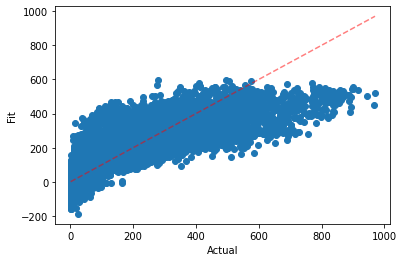

Test
---------------------------------
rmse 111.82
mae 80.82
mape 2.41


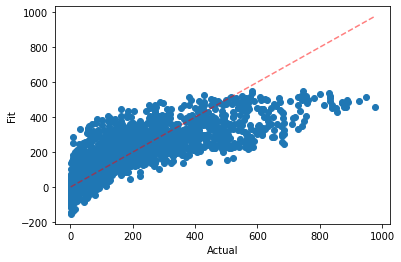

<IPython.core.display.Javascript object>

In [23]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

print("Train\n---------------------------------")
eval_preds(y_train, y_pred_train)
print("Test\n---------------------------------")
eval_preds(y_test, y_pred_test)

We want to fall evenly around that line.  Right now, we're underpredicting high values.  In our EDA we made a comment about our response's skewed distribution.  We might want to reconsider a transformation.  A log transformation is a good one to start with for right skewed data.

Refit the model on a logged version of `y`.

In [24]:
ridge.fit(X_train, np.log(y_train))

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

<IPython.core.display.Javascript object>

Re-evaluate the predictions

Train
---------------------------------
R^2: 0.80
rmse 113.55
mae 72.32
mape 0.67


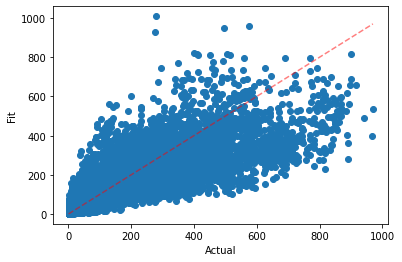

Test
---------------------------------
R^2: 0.80
rmse 114.50
mae 73.09
mape 0.69


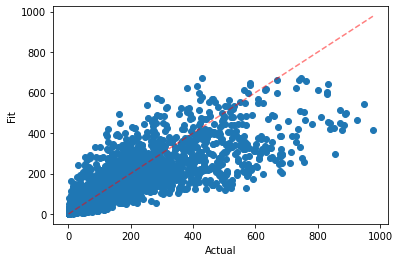

<IPython.core.display.Javascript object>

In [25]:
y_pred_train = np.exp(ridge.predict(X_train))
y_pred_test = np.exp(ridge.predict(X_test))

print("Train\n---------------------------------")
print(f"R^2: {ridge.score(X_train, np.log(y_train)):.2f}")
eval_preds(y_train, y_pred_train)
print("Test\n---------------------------------")
print(f"R^2: {ridge.score(X_test, np.log(y_test)):.2f}")
eval_preds(y_test, y_pred_test)

## Build a LASSO regression model 🤠

In [26]:
lasso = Lasso()
lasso.fit(X_train, np.log(y_train))

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

<IPython.core.display.Javascript object>

How are our coefficients looking now?

In [27]:
lasso.coef_

array([ 0.,  0.,  0., -0., -0.,  0.,  0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.])

<IPython.core.display.Javascript object>

Well... the coefficient shrinking definitely did its thing here... We probably want a better way of selecting an alpha than guess and check.  This is where cross validation comes into play paired with something called a gridsearch.  All the grid search does is find the best combination of hyperparameters that we tell it to test.  Here our only hyperparameter will be alpha.

Let's fit lasso using a gridsearch for the best alpha.  After we fit the model lets view the best alpha and the new coefficients.

In [28]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1]}

lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5)
lasso_cv.fit(X_train, np.log(y_train))

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 0.0001


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


array([ 0.31940899,  0.2251487 ,  0.55093498, -0.02192767, -0.53576213,
        0.        , -0.01004674, -0.15889737, -0.09653282, -0.11049697,
       -0.19538343, -0.17150114, -0.72928893, -1.20167595, -1.7661086 ,
       -2.05772374, -0.98974654,  0.27681242,  1.22003131,  1.88084297,
        1.52680827,  1.1821982 ,  1.27122855,  1.43868123,  1.42643515,
        1.3423628 ,  1.38881941,  1.65644481,  2.0599044 ,  2.00864174,
        1.74697997,  1.43193571,  1.17763361,  0.94629402,  0.55506404,
        0.32572732, -0.0716983 , -0.04700863,  0.00904796])

<IPython.core.display.Javascript object>

Evaluate the predictions

Train
---------------------------------
R^2: 0.80
rmse 112.06
mae 71.66
mape 0.66


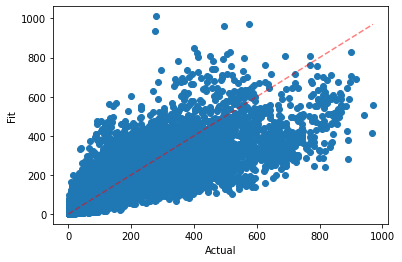

Test
---------------------------------
R^2: 0.80
rmse 113.02
mae 72.54
mape 0.68


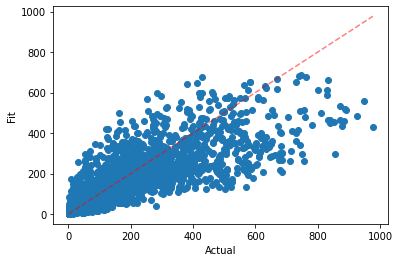

<IPython.core.display.Javascript object>

In [29]:
y_pred_train = np.exp(lasso_cv.predict(X_train))
y_pred_test = np.exp(lasso_cv.predict(X_test))

print("Train\n---------------------------------")
print(f"R^2: {lasso_cv.score(X_train, np.log(y_train)):.2f}")
eval_preds(y_train, y_pred_train)
print("Test\n---------------------------------")
print(f"R^2: {lasso_cv.score(X_test, np.log(y_test)):.2f}")
eval_preds(y_test, y_pred_test)

We're now on par with the ridge regression results.  Not the most fair comparison though, with ridge regression we didn't grid search, we just made up a value for alpha.  On your own you can implement grid search for the ridge regression and see how/if the results improve.

## Build an elasticnet regression model

In [30]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1], "l1_ratio": [0.1, 0.5, 0.75, 1]}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, np.log(y_train))

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 0.0001
selected l1_ratio: 1


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.2s finished


array([ 0.31940899,  0.2251487 ,  0.55093498, -0.02192767, -0.53576213,
        0.        , -0.01004674, -0.15889737, -0.09653282, -0.11049697,
       -0.19538343, -0.17150114, -0.72928893, -1.20167595, -1.7661086 ,
       -2.05772374, -0.98974654,  0.27681242,  1.22003131,  1.88084297,
        1.52680827,  1.1821982 ,  1.27122855,  1.43868123,  1.42643515,
        1.3423628 ,  1.38881941,  1.65644481,  2.0599044 ,  2.00864174,
        1.74697997,  1.43193571,  1.17763361,  0.94629402,  0.55506404,
        0.32572732, -0.0716983 , -0.04700863,  0.00904796])

<IPython.core.display.Javascript object>

The l1_ratio selected was 1.0... what does this mean?  It means ElasticNet decided to go with Lasso entirely instead of a mixture.

In [31]:
# Note that lasso decided to exclude weather_4 from the model
coef_df = pd.DataFrame()
coef_df["feat"] = X_train.columns
coef_df["coef"] = elasticnet_cv.best_estimator_.coef_
coef_df

,feat,coef
0,season_2,0.319409
1,season_3,0.225149
2,season_4,0.550935
3,weather_2,-0.021928
4,weather_3,-0.535762
5,weather_4,0.000000
6,weekday_Friday,-0.010047
7,weekday_Monday,-0.158897
8,weekday_Sunday,-0.096533
9,weekday_Thursday,-0.110497


<IPython.core.display.Javascript object>